# Random Forest Analysis of Balanced Datasets

Some typical imports and useful setup for the dataset:

In [ ]:
TEXT_FIELD = 'title'
TEXT_ENCODING = 'one-hot'
assert TEXT_FIELD in ('abstract', 'title'), 'TEXT_FIELD must be one of "title" or "abstract".'
assert TEXT_ENCODING in ('one-hot', 'tokenized'), 'TEXT_ENCODING must be one of "one-hot" or "tokenized".'
# The above choices determine the relevant sequence length of the data.
if TEXT_ENCODING == 'one-hot':
    SEQ_LEN = 128 if TEXT_FIELD == 'title' else 2048
else:
    SEQ_LEN = int(1.5 * 16) if TEXT_FIELD == 'title' else int(1.5 * 256)

In [ ]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
pd.set_option(u'float_format', '{:f}'.format)
import wandb

Fix a global random state to be used for all seeds:

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# Give the notebook access to the rest of your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing .py modules stored in FOLDERNAME or a subdirectory:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


In [ ]:
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
if TEXT_ENCODING == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
elif TEXT_FIELD == 'abstract':
    tokens_file_name = 'balanced_abstract_normalized_vocab.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{tokens_path}' .
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
tokens_df = pd.read_feather(tokens_file_name)
if TEXT_ENCODING == 'one-hot':
    text_to_idx = dict(zip(tokens_df.char.values, np.arange(len(tokens_df))))
else:
    # 0 and 1 are reserved for padding and <UNK> for embeddings.
    text_to_idx = dict(zip(tokens_df.word.values, np.arange(2, len(tokens_df) + 2)))
idx_to_text = {val: key for key, val in text_to_idx.items()}

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel.

In [ ]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)

balanced_title_rf


# Feature engineering

Focus only on the titles.

In [ ]:
train_data_title_source_df = train_data_df[['title', 'source']]
train_data_title_source_df.head()

,title,source
0,reits : reflective surface for intelligent tra...,arxiv
1,mirror images and division by zero calculus,vixra
2,electromagnetic waves in an expanding 5d universe,vixra
3,atomic - scale erector,vixra
4,temperature dependence of microwave and thz di...,arxiv


Add in a random column as a sanity check, inspired by [this post on RF feature importances](https://explained.ai/rf-importance/index.html).

In [ ]:
train_data_title_source_df['random'] = pd.Series(np.random.random(len(train_data_title_source_df)))

Let us first add various counting stats to the `DataFrame`

In [ ]:
train_data_title_source_df['char_len'] = train_data_title_source_df['title'].str.len()
train_data_title_source_df['numerical_percent'] = train_data_title_source_df['title'].apply(lambda x: sum(ch.isdigit() for ch in x)) / train_data_title_source_df['char_len']
train_data_title_source_df['longest_word'] = train_data_title_source_df['title'].apply(lambda x: np.max([len(word) for word in x.split()]))

Add columns for whether the starting or ending character is non-alphanumeric and not a blank space as well as counts/frequencies of these chars.  Some characters need escaping and we need to avoid performing `counts` with `|`, `.`, `^`, and `$` because `pd`'s `str.count` method takes in `regex` expressions, unlike `str.endswith` or `str.startswith`. We handle these edge cases by hand (annoyingly).


In [ ]:
for ch in tokens_df.char:
    if not ch.isalnum() and ch not in  (' ', '|', '.', '$', '^'):
        train_data_title_source_df[f'ends_with_{ch}'] = train_data_title_source_df.title.str.endswith(ch)
        train_data_title_source_df[f'starts_with_{ch}'] = train_data_title_source_df.title.str.startswith(ch)
        try:
            train_data_title_source_df[f'{ch}_percent'] = train_data_title_source_df.title.str.count(ch) / train_data_title_source_df.title.str.len()
        except Exception as e:
            print(e)
            print(f'Failed on character {ch}')

missing ), unterminated subpattern at position 0
Failed on character (
unbalanced parenthesis at position 0
Failed on character )
nothing to repeat at position 0
Failed on character *
nothing to repeat at position 0
Failed on character +
nothing to repeat at position 0
Failed on character ?
unterminated character set at position 0
Failed on character [
bad escape (end of pattern) at position 0
Failed on character \


Handling remaining cases:

In [ ]:
for ch in ('\(', '\)', '\*', '\+', '\?', '\[', '\|', '\\\\', '\.', '\$', '\^'):
    try:
        train_data_title_source_df[f'{ch[-1]}_percent'] = train_data_title_source_df.title.str.count(ch) / train_data_title_source_df.title.str.len()
    except Exception as e:
        print(e)
        print(f'failed on {ch}')

Some of the engineered features are trivial (all of which could be reasonably expected):

In [ ]:
trivial_features = [column_name for column_name, column_values  in train_data_title_source_df.drop('source', axis=1).iteritems() if not column_values.any()]
trivial_features

['starts_with_!',
 'starts_with_%',
 'ends_with_&',
 'starts_with_&',
 'ends_with_(',
 'starts_with_)',
 'starts_with_+',
 'starts_with_,',
 'starts_with_/',
 'starts_with_:',
 'ends_with_;',
 'starts_with_;',
 'ends_with_<',
 'starts_with_=',
 'starts_with_>',
 'starts_with_?',
 'ends_with_@',
 'starts_with_@',
 'ends_with_[',
 'ends_with_\\',
 'starts_with_]',
 'ends_with__',
 'starts_with__',
 'ends_with_`',
 'ends_with_{',
 'starts_with_}',
 'ends_with_~',
 'starts_with_~']

Remove them:

In [ ]:
train_data_title_source_df = train_data_title_source_df.drop(trivial_features, axis=1)

Let's compute the average rank of the words used in the abstracts and titles

In [ ]:
vocab_file_name = 'balanced_title_normalized_vocab.feather'
vocab_path = FOLDERNAME + SUBDIR + vocab_file_name
!cp '{vocab_path}' .
vocab_df = pd.read_feather(vocab_file_name)

The vocab `df` is ordered by rank of how common the words are. Very basic/naive preprocessing was applied such all forms of punctutation were also included as words.

In [ ]:
vocab_df

,word,count
0,of,16881
1,-,15158
2,the,13569
3,and,9737
4,in,7861
...,...,...
23941,condensing,1
23942,anyone,1
23943,highlighting,1
23944,snippets,1


Create a small function to compute word mean word rank.

Create the word-rank dictionary first.

In [ ]:
vocab_rank_word_dict = vocab_df['word'].to_dict()
vocab_word_rank_dict = {val: key for key, val in vocab_rank_word_dict.items()}

In [ ]:
def mean_word_rank(text, word_rank_dict=vocab_word_rank_dict):
    highest_rank = len(word_rank_dict) + 1
    words = text.split()
    ranks = np.array([word_rank_dict.get(w, highest_rank) for w in words])
    return ranks.mean()

In [ ]:
train_data_title_source_df['mean_word_rank'] = train_data_title_source_df.title.apply(mean_word_rank)

In [ ]:
train_data_title_source_df

,title,source,random,char_len,numerical_percent,longest_word,ends_with_!,!_percent,"ends_with_""","starts_with_""","""_percent",ends_with_#,starts_with_#,#_percent,ends_with_%,%_percent,&_percent,ends_with_',starts_with_','_percent,starts_with_(,ends_with_),ends_with_*,starts_with_*,ends_with_+,"ends_with_,",",_percent",ends_with_-,starts_with_-,-_percent,ends_with_/,/_percent,ends_with_:,:_percent,;_percent,starts_with_<,<_percent,ends_with_=,=_percent,ends_with_>,>_percent,ends_with_?,@_percent,starts_with_[,starts_with_\,ends_with_],]_percent,__percent,starts_with_`,`_percent,starts_with_{,{_percent,ends_with_},}_percent,~_percent,(_percent,)_percent,*_percent,+_percent,?_percent,[_percent,|_percent,\_percent,._percent,$_percent,^_percent,mean_word_rank
0,reits : reflective surface for intelligent tra...,arxiv,0.374540,65,0.000000,14,False,0.000000,False,False,0.000000,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,False,False,False,False,False,0.000000,False,False,0.000000,False,0.000000,False,0.015385,0.000000,False,0.000000,False,0.000000,False,0.000000,False,0.000000,False,False,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2773.250000
1,mirror images and division by zero calculus,vixra,0.950714,43,0.000000,8,False,0.000000,False,False,0.000000,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,False,False,False,False,False,0.000000,False,False,0.000000,False,0.000000,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,False,0.000000,False,False,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,459.285714
2,electromagnetic waves in an expanding 5d universe,vixra,0.731994,49,0.020408,15,False,0.000000,False,False,0.000000,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,False,False,False,False,False,0.000000,False,False,0.000000,False,0.000000,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,False,0.000000,False,False,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,739.571429
3,atomic - scale erector,vixra,0.598658,22,0.000000,7,False,0.000000,False,False,0.000000,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,False,False,False,False,False,0.000000,False,False,0.045455,False,0.000000,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,False,0.000000,False,False,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3031.250000
4,temperature dependence of microwave and thz di...,arxiv,0.156019,98,0.051020,11,False,0.000000,False,False,0.000000,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,True,False,False,False,False,0.000000,False,False,0.010204,False,0.000000,False,0.000000,0.000000,False,0.000000,False,0.010204,False,0.000000,False,0.000000,False,False,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,0.000000,0.010204,0.010204,0.000000,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1677.523810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35137,"stimulated topological condensation of "" vapou...",vixra,0.310009,116,0.000000,12,False,0.000000,False,False,0.017241,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,False,False,False,False,False,0.000000,False,False,

Perform the same computation on common words which appear more than 5 times and which are longer than 4 chars, say.

# Validation Set Feature Engineering

Performing all of the same steps on the validation set. Create a helper function which acts on a `DataFrame` with a `title` and `source` column.

In [ ]:
def feature_engineering_helper(df, trivial_features=None):
    titles_source_df = df[['title', 'source']]
    titles_source_df['random'] = pd.Series(np.random.randn(len(titles_source_df)))
    # Avoid counting blank space.
    titles_source_df['char_len'] = titles_source_df['title'].str.len()
    titles_source_df['numerical_percent'] = titles_source_df['title'].apply(lambda x: sum(ch.isdigit() for ch in x)) / titles_source_df['char_len']
    titles_source_df['longest_word'] = titles_source_df['title'].apply(lambda x: np.max([len(word) for word in x.split()]))
    for ch in tokens_df.char:
        if not ch.isalnum() and ch not in  (' ', '|', '.', '$', '^'):
            titles_source_df[f'ends_with_{ch}'] = titles_source_df.title.str.endswith(ch)
            titles_source_df[f'starts_with_{ch}'] = titles_source_df.title.str.startswith(ch)
            try:
                titles_source_df[f'{ch}_percent'] = titles_source_df.title.str.count(ch) / titles_source_df.title.str.len()
            except Exception as e:
                print(e)
                print(f'Failed on character {ch}')
    for ch in ('\(', '\)', '\*', '\+', '\?', '\[', '\|', '\\\\', '\.', '\$', '^'):
        try:
            titles_source_df[f'{ch[-1]}_percent'] = titles_source_df.title.str.count(ch) / titles_source_df.title.str.len()
        except Exception as e:
            print(e)
            print(f'failed on {ch}')
    titles_source_df['mean_word_rank'] = titles_source_df.title.apply(mean_word_rank)
    if trivial_features is not None:
        titles_source_df = titles_source_df.drop(trivial_features, axis=1)
    return titles_source_df

In [ ]:
val_data_title_source_df = feature_engineering_helper(val_data_df, trivial_features=trivial_features)

missing ), unterminated subpattern at position 0
Failed on character (
unbalanced parenthesis at position 0
Failed on character )
nothing to repeat at position 0
Failed on character *
nothing to repeat at position 0
Failed on character +
nothing to repeat at position 0
Failed on character ?
unterminated character set at position 0
Failed on character [
bad escape (end of pattern) at position 0
Failed on character \


# Visualize

View the corner plot for some selected categories

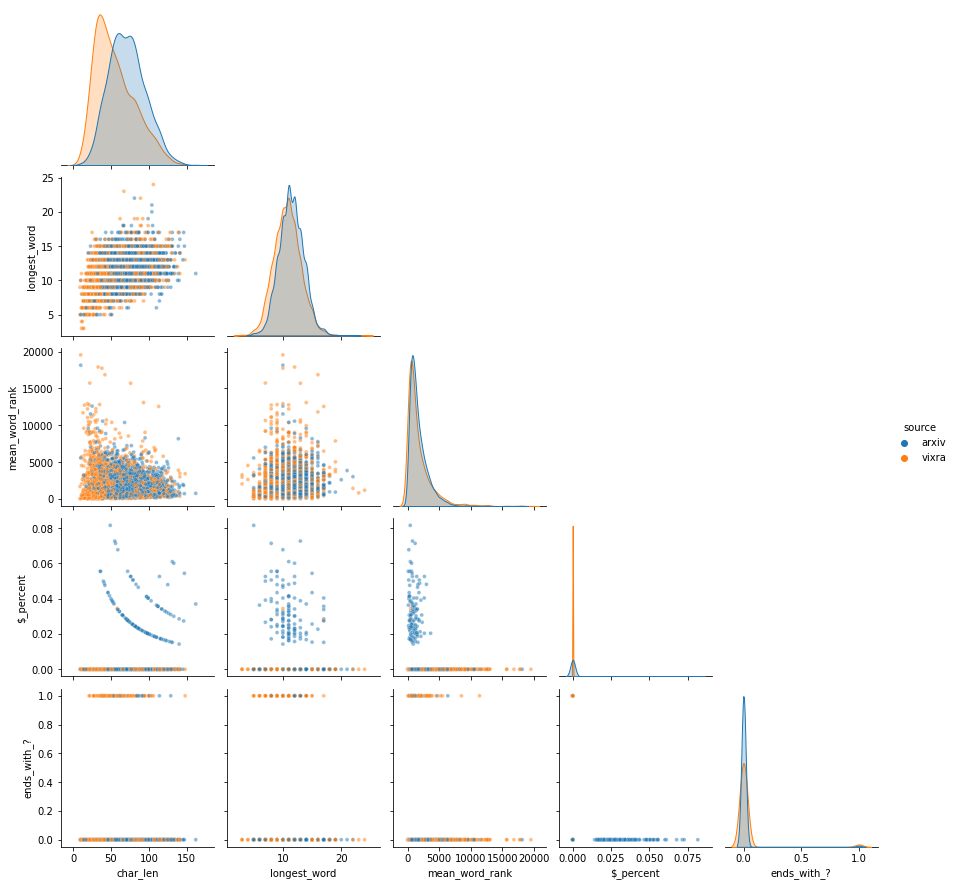

In [ ]:
# Visualize a random sample.
plot_cats = ['char_len', 'longest_word', 'mean_word_rank', '$_percent','ends_with_?', 'source']
corner_plot_df = train_data_title_source_df.sample(5000, random_state=RANDOM_STATE)[plot_cats]
train_data_title_source_df_corner_plot = sns.pairplot(data=corner_plot_df,
             hue='source',
             plot_kws={'s': 15, 'alpha': .5},
             corner=True)
train_data_title_source_df_corner_plot.fig.savefig(FOLDERNAME + '/figures/rf_feature_engineering_corner_plot.png', bbox_inches='tight')

The family of `$_percent`-`char_len` curves correspond to the possible number of `$`'s in the title, each decaying as $\frac{1}{\texttt{char_len}}$.

Though large-`$_percent` entries are almost sure to be `arxiv`, there aren't very many such examples as a fraction of the dataset:

In [ ]:
# ~20 : 1 ratio of high-$_percent arxiv : vixra papers
high_dollar_mask = (train_data_title_source_df['$_percent'] > .01)
print('High-$ arxiv papers count:', (train_data_title_source_df[high_dollar_mask]['source'] == 'arxiv').sum())
print('High-$ vixra papers count:', (train_data_title_source_df[high_dollar_mask]['source'] == 'vixra').sum())
# But, only a small fraction of all such have this many $:
print('Percent high-$ papers:', high_dollar_mask.mean())

High-$ arxiv papers count: 858
High-$ vixra papers count: 40
Percent high-$ papers: 0.025553468783791475


Finally, inspect the correlation matrix.  This can be a good place to catch errors (as when I caught several issues due to `pd`'s `str.count` method taking `regex` strings, in contrast to its `str.endswith` and `str.startswith` methods). The relatively highly-correlated features are all reasonable, e.g., `$_percent` and `^_percent` since carets usually appear for `latex` reasons and are hence wrapped in dollar-signs.

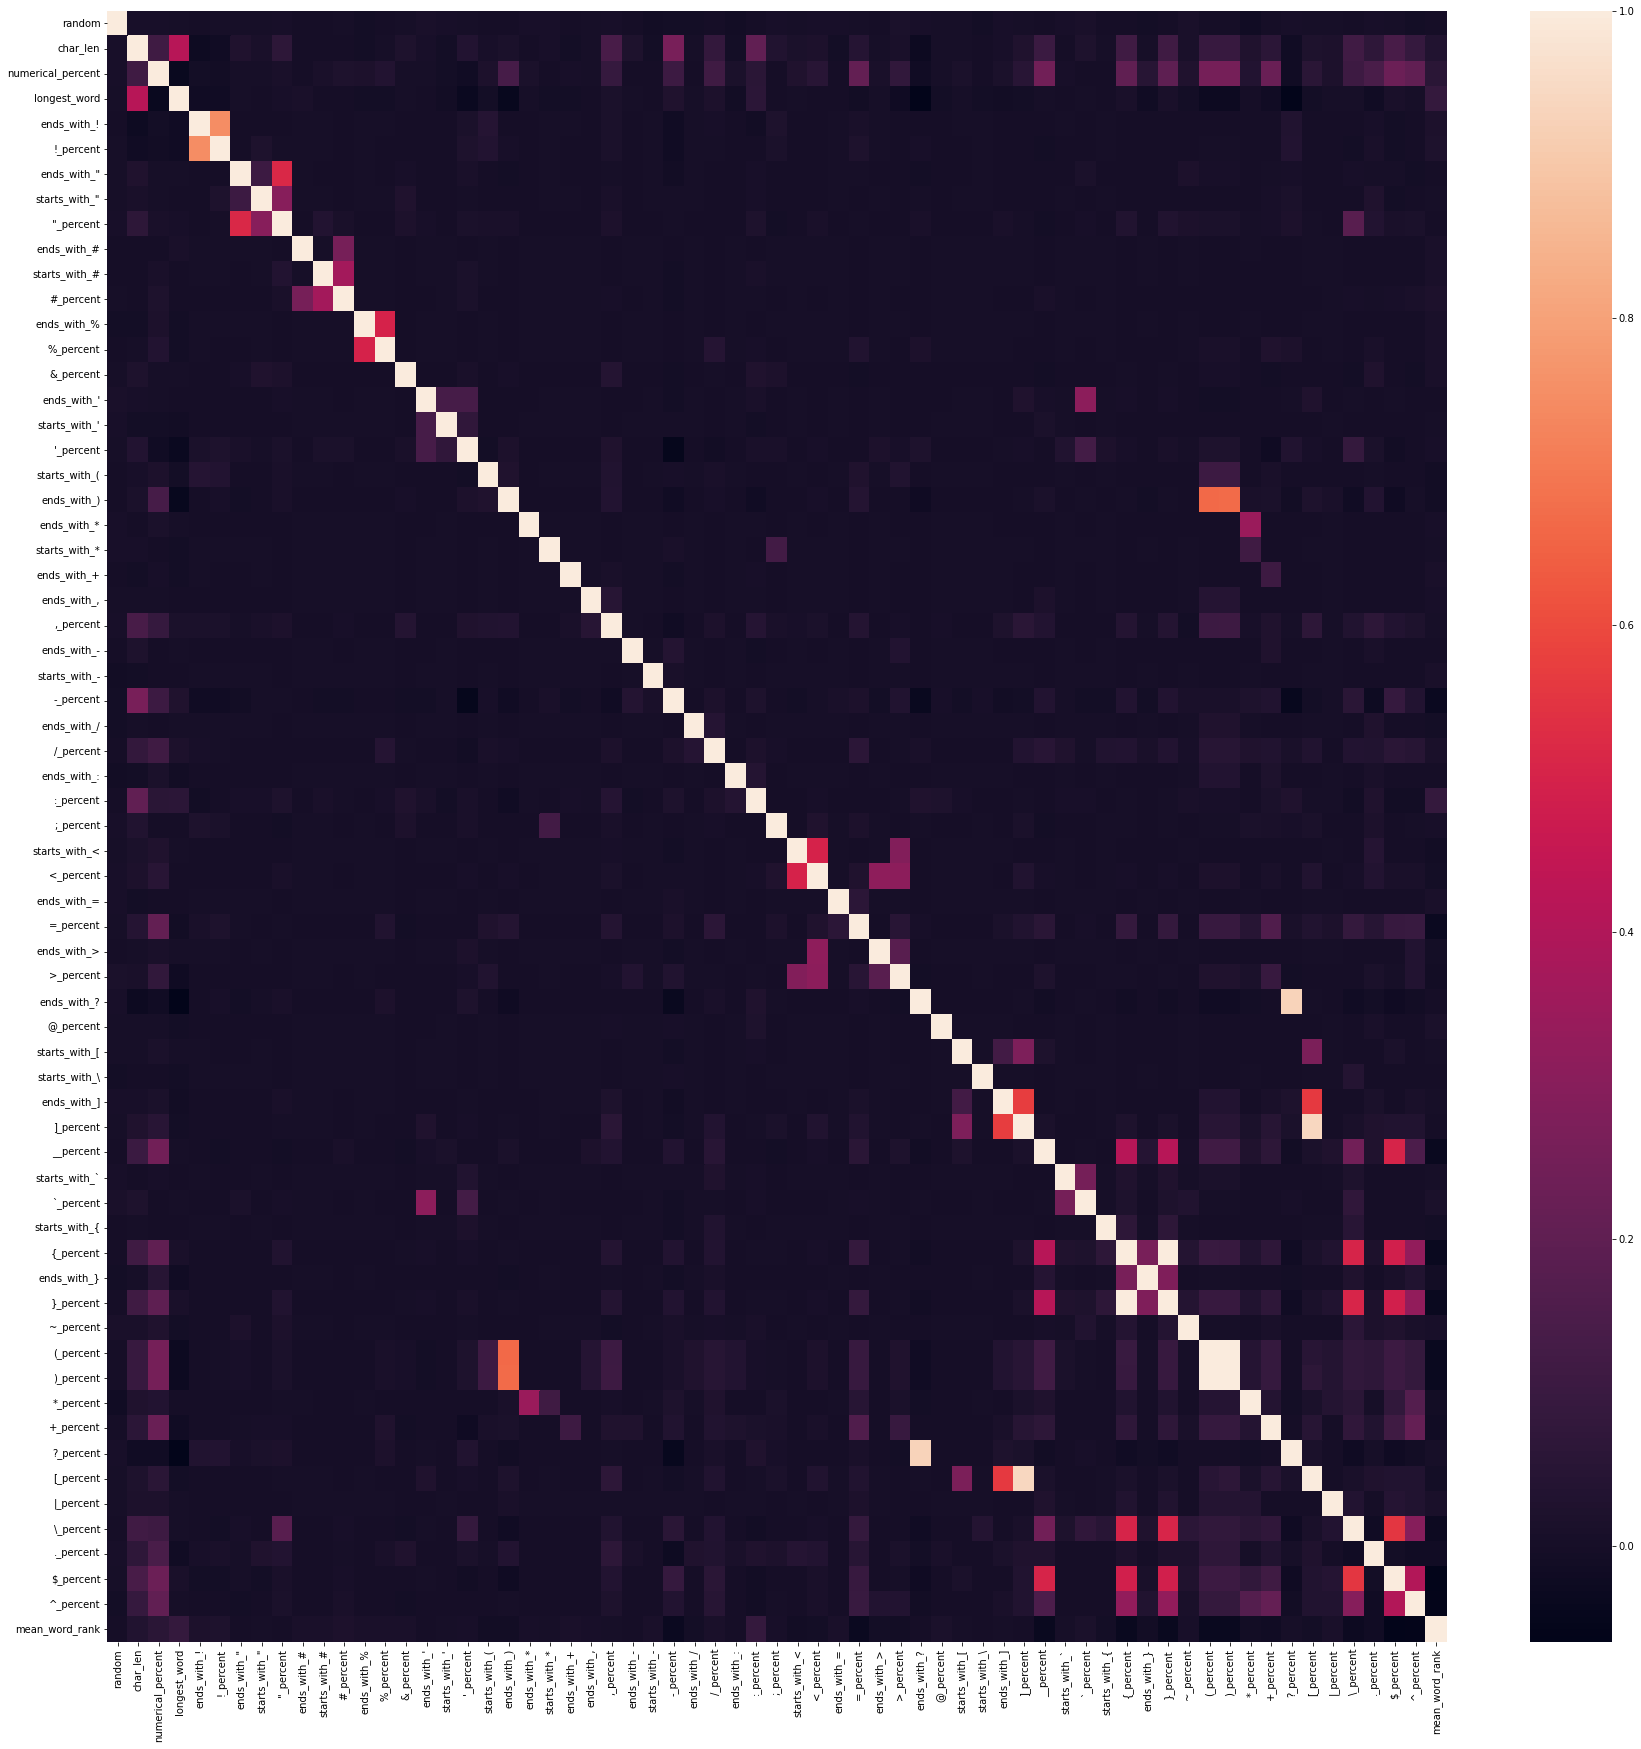

In [ ]:
plt.figure(figsize = (30, 30))
train_data_title_source_df_sperman_corr = train_data_title_source_df.corr(method='spearman')
sns.heatmap(train_data_title_source_df_sperman_corr)

# Random Forest Hyperparameter Tuning

In [ ]:
def tree_hyper_loop(train_df,
                    iterations=10,
                    random_state=None,
                    **sweep_args):
    """Randomized hyperparameter tuning for RandomForestClassifier.
    Pass in any array-like object for any of the standard RF hyperparameters
    args to randomly scan over the contained values.  Results judged by OOB
    score. Can optionally fix the random state of the RF.

    Example::
        # Scan over various choices of n_estimators.
        tree_hyper_loop(train_df,
                        val_df,
                        n_estimators=[2, 5, 10, 15])
    """
    results = []
    for num in range(iterations):
        print(f'Step {num + 1} of {iterations}...')
        # Default args for performance:
        performance_args = {'oob_score': True,
                     'n_jobs': -1,}
        # Randomly choose hyperparameters among those provided in sweep_args.
        rand_args = {}
        for key, val in sweep_args.items():
            if val is not None:
                rand_args[key] = np.random.choice([p for p in val])
        print(f'Sweep parameters:')
        for key, val in rand_args.items():
            print(f'\t\t{key}: {val}')

        rf_args = {**performance_args, **rand_args}
        if random_state is not None:
            rf_args['random_state'] = random_state
        rf = RandomForestClassifier(**rf_args)
        train_df_features, train_df_labels = train_df.drop(['source', 'title'], axis=1), train_df['source']
        rf.fit(train_df_features, train_df_labels)
        result = {'train_score': rf.score(train_df_features, train_df_labels),
                  'oob_score': rf.oob_score_,
                  'rf_args': rf_args}

        print(f'Scores:')
        for key, val in result.items():
            if key.split('_')[-1] == 'score':
                print(f'\t\t{key}: {val}')
        print('\n' + 50 * '-')


        results.append(result)

        
    results.sort(key=lambda x: x['oob_score'], reverse=True)
    return results        

Run some random trials using a subset of the data. Choose somewhat generous numbers for `min_samples_leaf` to help with generalziation. (Also, empirically, a low $\mathcal{O}(1)$ `min_samples_leaf` seems to lead to results where the `random` column has a non-trivial permutation-based importance measure, which I took as evidence for overfitting).

*Interesting side note:* if no pruning is performed (i.e. `min_samples_leaf=1`, `max_depth=None`, and similar) one should *expect* to acheive a *training* accuracy of 1 in a binary RF problem. This is because every training example will appear in $\approx 1/ e = 63\%$ of all training trees and so the majority rule vote on any given training example will lead to correct classification;[see here](https://towardsdatascience.com/one-common-misconception-about-random-forest-and-overfitting-47cae2e2c23b)  Found this out after achieving 'train_score=1' for some hyperparameter choices.

In [ ]:
# The sklearn warning about feature names is due to the presence of column
# labels on the training data.

rf_hyper_trials = tree_hyper_loop(train_data_title_source_df.sample(frac=.2, random_state=RANDOM_STATE),
                                  n_estimators=np.random.randint(100, 500, 100),
                                  min_samples_leaf=np.random.randint(25, 100, 100),
                                  max_features=['sqrt', 'log2'],
                                  random_state=RANDOM_STATE,
                                  iterations=20)

Step 1 of 20...
Sweep parameters:
		n_estimators: 124
		min_samples_leaf: 26
		max_features: sqrt
Scores:
		train_score: 0.703187250996016
		oob_score: 0.6896698918611269

--------------------------------------------------
Step 2 of 20...
Sweep parameters:
		n_estimators: 314
		min_samples_leaf: 69
		max_features: sqrt
Scores:
		train_score: 0.6982071713147411
		oob_score: 0.6891007398975526

--------------------------------------------------
Step 3 of 20...
Sweep parameters:
		n_estimators: 434
		min_samples_leaf: 64
		max_features: log2
Scores:
		train_score: 0.6990608992601024
		oob_score: 0.688673875924872

--------------------------------------------------
Step 4 of 20...
Sweep parameters:
		n_estimators: 248
		min_samples_leaf: 76
		max_features: log2
Scores:
		train_score: 0.6992031872509961
		oob_score: 0.6895276038702334

--------------------------------------------------
Step 5 of 20...
Sweep parameters:
		n_estimators: 389
		min_samples_leaf: 48
		max_features: sqrt
Scores:


Inspect the best-performing hyperparameter combinations.

In [ ]:
rf_hyper_trials[:3]

[{'oob_score': 0.6920887877063175,
  'rf_args': {'max_features': 'sqrt',
   'min_samples_leaf': 38,
   'n_estimators': 250,
   'n_jobs': -1,
   'oob_score': True,
   'random_state': 42},
  'train_score': 0.7016220830961867},
 {'oob_score': 0.691946499715424,
  'rf_args': {'max_features': 'sqrt',
   'min_samples_leaf': 35,
   'n_estimators': 331,
   'n_jobs': -1,
   'oob_score': True,
   'random_state': 42},
  'train_score': 0.701195219123506},
 {'oob_score': 0.6912350597609562,
  'rf_args': {'max_features': 'log2',
   'min_samples_leaf': 28,
   'n_estimators': 297,
   'n_jobs': -1,
   'oob_score': True,
   'random_state': 42},
  'train_score': 0.701195219123506}]

In [ ]:
rf_args_best = rf_hyper_trials[0]['rf_args']
rf_args_best

{'max_features': 'sqrt',
 'min_samples_leaf': 38,
 'n_estimators': 250,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42}

# Fine-Tune and Inspect Features

Use the best-performing hyperparameters to re-train on additional data using only the features with significant importance.  The main purpose of this re-training is to improve interpretability, not performance (though the latter shouldn't suffer much, if at all)

In [ ]:
from sklearn.inspection import permutation_importance

Create a small training function which allows us to train only on a subset of columns and performs both gini-impurity-based and permutation-based feature-importance computations; [see here.](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.htmlhttps://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

In [ ]:
def train_rf(train_df,
             val_df,
             rf_args,
             random_state=None,
             columns=None):
    """Simple training loop for a random forest. Returns a tuple of the model,
    a dict of its various scores, and a df of feature importances and their
    standard deviations (computed over estimators) both by Gini impurity
    decrease and by permutation-based importance. 
    """
    if random_state is not None:
        rf_args['random_state'] = random_state
    rf = RandomForestClassifier(**rf_args)
    if columns is None:
        train_df_features, train_df_labels = train_df.drop(['source', 'title'], axis=1), train_df['source']
        val_df_features, val_df_labels = val_df.drop(['source', 'title'], axis=1), val_df['source']
    else:
        train_df_features, train_df_labels = train_df[columns], train_df['source']
        val_df_features, val_df_labels = val_df[columns], val_df['source']
    rf.fit(train_df_features, train_df_labels)
    scores = {'val_score': rf.score(val_df_features, val_df_labels),
              'train_score': rf.score(train_df_features, train_df_labels),
              'oob_score': rf.oob_score_
                         }
    # Gini importances.
    gini_import = rf.feature_importances_
    gini_std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    gini_import_df = pd.DataFrame({'gini_import': gini_import,
                                   'gini_std': gini_std},
                                   index=train_df_features.columns)
    gini_import_df.sort_values(by='gini_import', inplace=True)
    # Permutation importances.
    perm_import = permutation_importance(rf,
                                         val_df_features,
                                         val_df_labels,
                                         random_state=RANDOM_STATE,
                                         n_jobs=-1,
                                         n_repeats=10)
    perm_import_df = pd.DataFrame({'perm_import': perm_import.importances_mean,
                                   'perm_std': perm_import.importances_std},
                                  index=val_df_features.columns)
    perm_import_df.sort_values(by='perm_import', inplace=True)

    return rf, scores, gini_import_df, perm_import_df

We will iteratively pick out the features which seem to be driving the results the most. Retrain the model on the full training set, examine the scores, and plot the feature importances.

In [ ]:
rf_0, rf_0_scores, rf_0_gini_import, rf_0_perm_import = train_rf(train_data_title_source_df,
                                                                 val_data_title_source_df,
                                                                 rf_args=rf_args_best,
                                                                 random_state=RANDOM_STATE,
                                                                 columns=None)

Inspect the scores:

In [ ]:
rf_0_scores

{'oob_score': 0.6999886176085596,
 'train_score': 0.7048545899493484,
 'val_score': 0.703718459495352}

Compare the two feature importance measures.

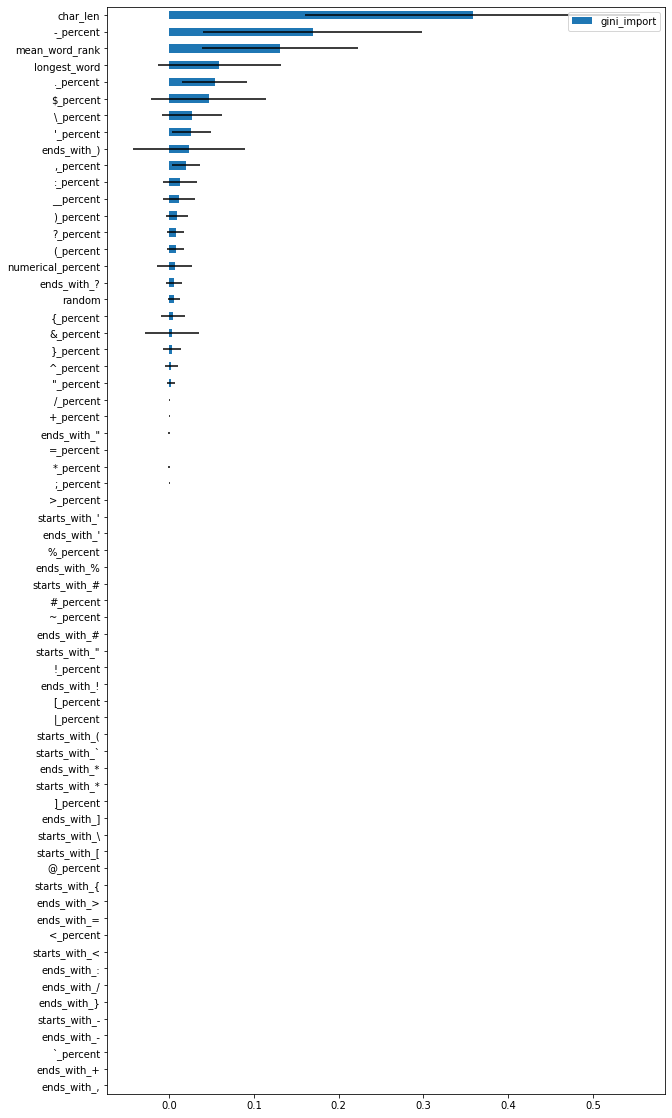

In [ ]:
rf_0_gini_import_plt = rf_0_gini_import.plot.barh(y='gini_import',
                                                  xerr='gini_std',
                                                  figsize=(10, 20)
                                                  )
rf_0_gini_import_plt.figure.savefig(FOLDERNAME + '/figures/rf_0_gini_import_plt.svg', bbox_inches='tight')

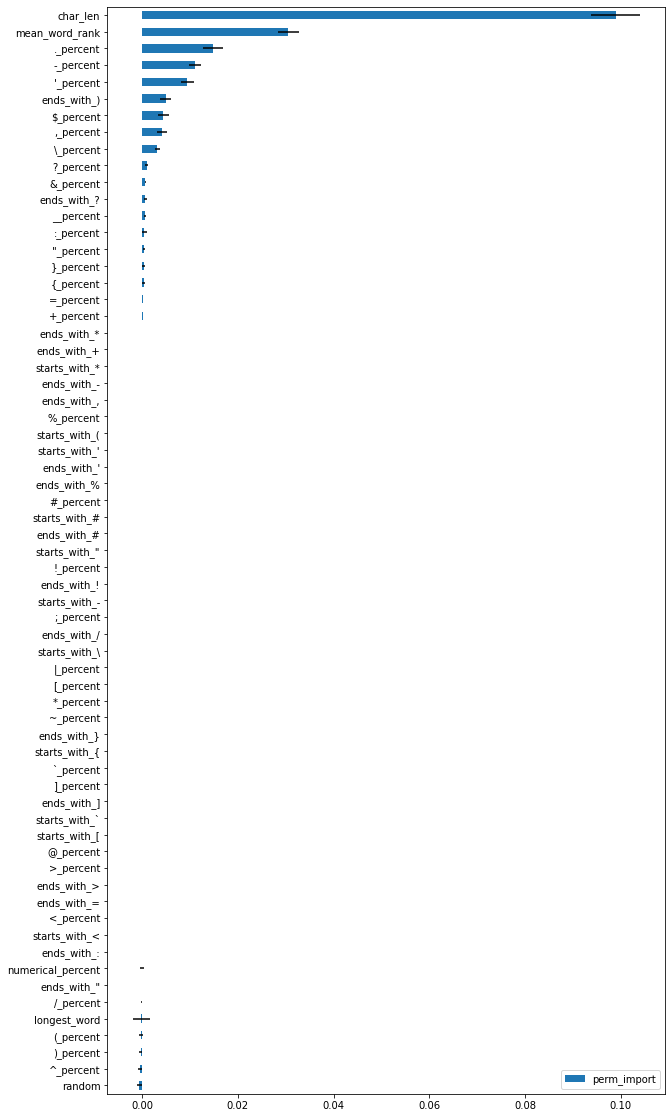

In [ ]:
rf_0_perm_import_plt = rf_0_perm_import.plot.barh(y='perm_import',
                                                  xerr='perm_std',
                                                  figsize=(10, 20))
rf_0_perm_import_plt.figure.savefig(FOLDERNAME + '/figures/rf_0_perm_import_plt.svg', bbox_inches='tight')

Pretty different looking! The error bars are very different, but they also correspond to difference variance computations: the Gini importance error bars come from a variance computed over trees, while for the permutation  importance we perform some number of shuffles (the `n_repeats` arg, default 5, in `permutation_importance`) and the error bars come from the variance across those shuffles. So, they're not directly comparable.

  Compare how they have ranked the `random` column (which again consisted of random numbers as a sanity check):

In [ ]:
for name, i in (('gini', rf_0_gini_import['gini_import']), ('perm', rf_0_perm_import['perm_import'])):
    print(f"{name} places 'random' in rank {i.rank(ascending=False)['random']} out of {len(i)}")

gini places 'random' in rank 18.0 out of 65
perm places 'random' in rank 65.0 out of 65


Not very reasonable for the gini measure! Precisely mirrors the example given [by Jeremy Howard and co-authors here](https://explained.ai/rf-importance/index.html), presumably for similar reasons, namely that purely by chance there may exist splits on the `random` column which are informative for the training set (roughly a form of the [look-elsewhere effect](https://en.wikipedia.org/wiki/Look-elsewhere_effect)). This has a greater effect on gini-based importance than permutation-based importance, apparently.

Let us re-train based on, say, the top `x` features, with `x` the number of features predicted to be more important than `random` in by gini importance.

In [ ]:
num_cols = 10
top_gini_cols = rf_0_gini_import.sort_values(by='gini_import', ascending=False)[:num_cols].index
top_perm_cols = rf_0_perm_import.sort_values(by='perm_import', ascending=False)[:num_cols].index

The differences in the columns used:

In [ ]:
set(top_gini_cols.values) - set(top_perm_cols.values)

{'longest_word'}

In [ ]:
set(top_perm_cols.values) - set(top_gini_cols.values)

{'?_percent'}

In [ ]:
# gini cols:
rf_1g, rf_1g_scores, rf_1g_gini_import, rf_1g_perm_import = train_rf(train_data_title_source_df,
                                                                     val_data_title_source_df,
                                                                     rf_args_best,
                                                                     random_state=RANDOM_STATE,
                                                                     columns=top_gini_cols)
# perm cols:
rf_1p, rf_1p_scores, rf_1p_gini_import, rf_1p_perm_import = train_rf(train_data_title_source_df,
                                                                     val_data_title_source_df,
                                                                     rf_args_best,
                                                                     random_state=RANDOM_STATE,
                                                                     columns=top_perm_cols)

Not a huge difference in accuracy, ultimately.

In [ ]:
pd.DataFrame({'rf_0': rf_0_scores,
              'rf_1g': rf_1g_scores,
              'rf_1p': rf_1p_scores
              })

,rf_0,rf_1g,rf_1p
val_score,0.703718,0.706906,0.711952
train_score,0.704855,0.708838,0.706790
oob_score,0.699989,0.699135,0.698936


# Final Model

Let us move forward with the model which keeps only the top perm-importance based features.  The perm-based feature-importances:

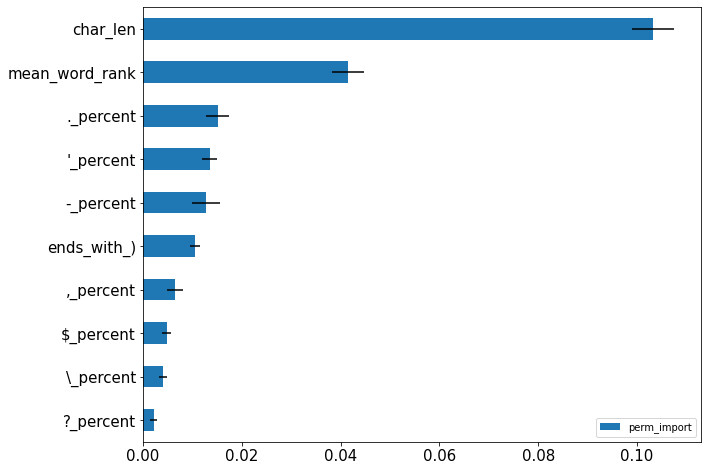

In [ ]:
rf_1p_perm_import_plt = rf_1p_perm_import.plot.barh(y='perm_import',
                                                    xerr='perm_std',
                                                    figsize=(10, 8))
plt.tick_params(axis='both', which='major', labelsize=15)
rf_1p_perm_import_plt.figure.savefig(FOLDERNAME + '/figures/rf_1p_perm_import_plt.svg', bbox_inches='tight')

Run the predictions on my own papers:

In [ ]:
goon_papers_df = pd.read_feather(FOLDERNAME + '/data/goon_papers.feather')[[TEXT_FIELD, 'source']]
display(goon_papers_df)

,title,source
0,"quantum corrections to generic branes : dbi , ...",arxiv
1,universal relation between corrections to entr...,arxiv
2,primordial non - gaussianity,arxiv
3,"superluminality , black holes and eft",arxiv
4,shapes of gravity : tensor non - gaussianity a...,arxiv
5,the effective theory of shift - symmetric cosm...,arxiv
6,partially massless fields during inflation,arxiv
7,soft theorems for shift - symmetric cosmologies,arxiv
8,heavy fields and gravity,arxiv
9,aspects of galileon non - renormalization,arxiv


Run the same feature engineering and get predictions:

In [ ]:
goon_papers_df_engineered = feature_engineering_helper(goon_papers_df, trivial_features=trivial_features)
goon_papers_df_engineered_predictions = rf_1p.predict(goon_papers_df_engineered[top_perm_cols])

missing ), unterminated subpattern at position 0
Failed on character (
unbalanced parenthesis at position 0
Failed on character )
nothing to repeat at position 0
Failed on character *
nothing to repeat at position 0
Failed on character +
nothing to repeat at position 0
Failed on character ?
unterminated character set at position 0
Failed on character [
bad escape (end of pattern) at position 0
Failed on character \


Not great results!

In [ ]:
(goon_papers_df_engineered_predictions == 'arxiv').mean()

0.5

The RF makes predictions by majority vote amongst its various trees. Let's inspect on a more granular level by seeing the mean results for the full set of trees for each prediction:

In [ ]:
%%capture
goon_papers_df_engineered_tree_preds = np.stack([tree.predict(goon_papers_df_engineered[top_perm_cols]) for tree in rf_1p.estimators_], axis=-1)
goon_papers_df['rf_pred_mean'] = goon_papers_df_engineered_tree_preds.mean(axis=-1)
goon_papers_df.sort_values(by='rf_pred_mean', inplace=True)

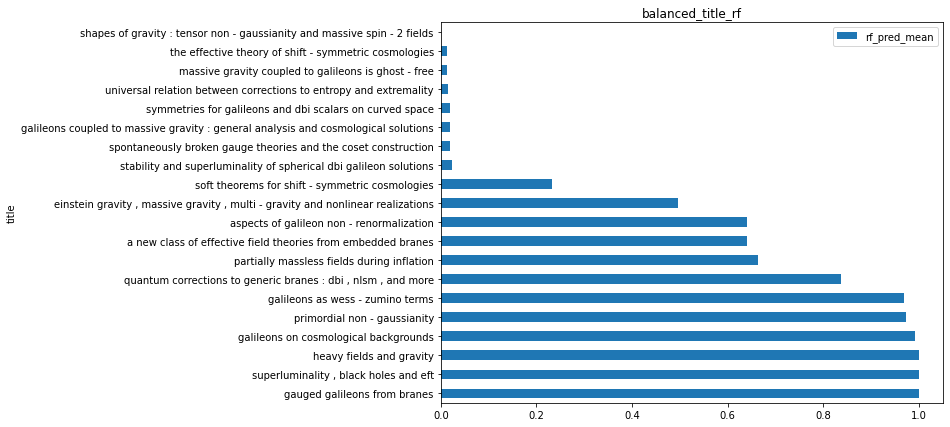

In [ ]:
goon_papers_df_tree_pred_plot = goon_papers_df.sort_values(by='rf_pred_mean', ascending=False).plot.barh(x='title',
                                                        y='rf_pred_mean',
                                                        title=PROJECT,
                                                        figsize=(9, 7))
goon_papers_df_tree_pred_plot.figure.savefig(FOLDERNAME + '/figures/goon_papers_df_tree_pred_plot.svg', bbox_inches='tight')

The RF model is 100% confident that some of my papers must be arXiv and others viXra (with both false-positives and false-negatives in the mix):

In [ ]:
goon_papers_df['rf_pred'] = goon_papers_df_engineered_predictions
with pd.option_context('display.max_colwidth', None):
    display(goon_papers_df.sort_values(by='rf_pred_mean', ascending=False))

,title,source,rf_pred_mean,rf_pred
15,gauged galileons from branes,arxiv,1.000000,arxiv
3,"superluminality , black holes and eft",arxiv,1.000000,vixra
8,heavy fields and gravity,arxiv,1.000000,arxiv
16,galileons on cosmological backgrounds,arxiv,0.992000,vixra
2,primordial non - gaussianity,arxiv,0.972000,vixra
14,galileons as wess - zumino terms,arxiv,0.968000,vixra
0,"quantum corrections to generic branes : dbi , nlsm , and more",arxiv,0.836000,arxiv
6,partially massless fields during inflation,arxiv,0.664000,arxiv
18,a new class of effective field theories from embedded branes,arxiv,0.640000,arxiv
9,aspects of galileon non - renormalization,arxiv,0.640000,arxiv


Let's try and see what is going on in the very confident predictions using `dtreeviz`:

In [ ]:
%%capture --no-stderr
!pip install dtreeviz            
from sklearn.datasets import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

Take the paper which was most strongly predicted to be vixra and visualize its prediction path using a randomly selected tree:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/dtreeviz/trees.py:1032: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(*overall_feature_range_wide)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


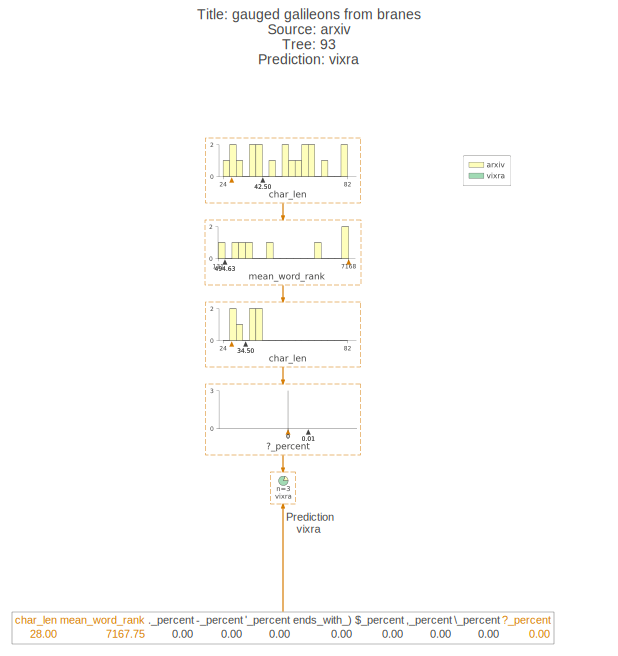

In [ ]:
goon_df_idx = goon_papers_df.iloc[-1].name
goon_df_data_point = goon_papers_df_engineered.iloc[goon_df_idx]
rf_1p_rand_tree_idx = np.random.randint(len(rf_1p.estimators_))
rf_1p_rand_tree = rf_1p.estimators_[rf_1p_rand_tree_idx]
rf_1p_rand_tree_pred = rf_1p_rand_tree.predict(goon_df_data_point[top_perm_cols].values.reshape(1, -1))
rf_1p_rand_tree_viz = dtreeviz(rf_1p_rand_tree,
                               goon_papers_df_engineered[top_perm_cols],
                               goon_papers_df_engineered['source'].apply(lambda x: x =='vixra'),
                               feature_names = [s.replace('&', 'ampersand') for s in top_perm_cols], # Avoids SVG error.
                               class_names=['arxiv', 'vixra'],
                               X=goon_df_data_point[top_perm_cols].values,
                               show_just_path=True,
                               title=f"Title: {goon_df_data_point.title}\n Source: {goon_df_data_point.source}\n Tree: {rf_1p_rand_tree_idx}\n Prediction: {'vixra' if rf_1p_rand_tree_pred else 'arxiv'}",
         )
rf_1p_rand_tree_viz.save(FOLDERNAME + '/figures/rf_1p_rand_tree_viz.svg')
rf_1p_rand_tree_viz

The similar plot for a sample from the validation set is more unweildy:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


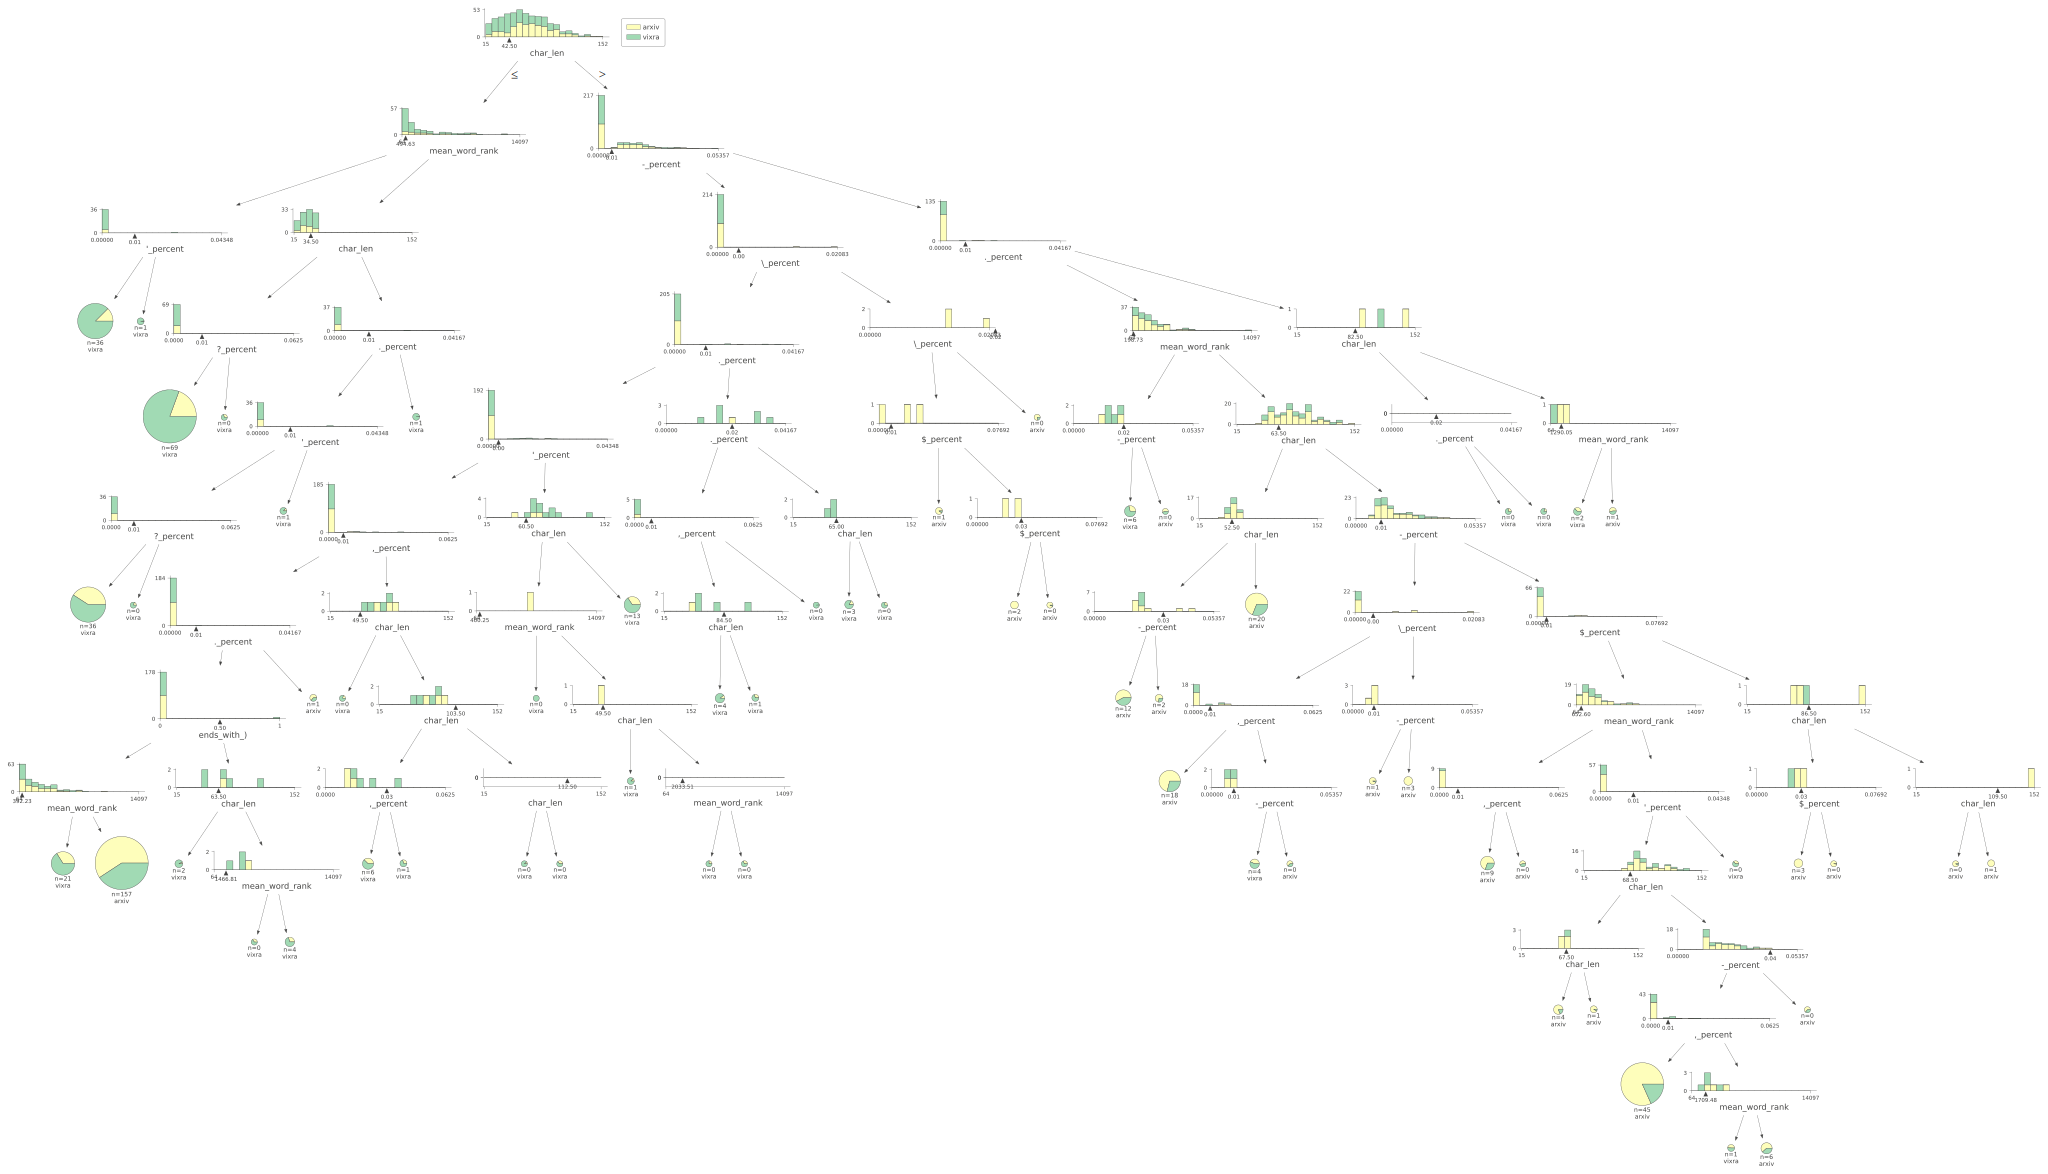

In [ ]:
val_data_title_source_df_sample = val_data_title_source_df.sample(500, random_state=RANDOM_STATE)
rf_1p_rand_tree_full_viz = dtreeviz(rf_1p_rand_tree,
                                    val_data_title_source_df_sample[top_perm_cols],
                                    val_data_title_source_df_sample['source'].apply(lambda x: x =='vixra'),
                                    feature_names = [s.replace('&', 'ampersand') for s in top_perm_cols], # Avoids SVG error.
                                    class_names=['arxiv', 'vixra'],
         )
rf_1p_rand_tree_full_viz.save(FOLDERNAME + '/figures/rf_1p_rand_tree_full_viz.svg')
rf_1p_rand_tree_full_viz

Write the model to our final models folder:

In [ ]:
import joblib
joblib.dump(rf_1g, FOLDERNAME + '/final_models/' + PROJECT + '.joblib')

['/content/drive/My Drive/ML/arxiv_vixra/final_models/balanced_title_rf.joblib']